# Risk Management II: Risk Measures

There have been several attempts at defining a single measure to summarise the total risk in a portfolio. This would make it easy to compare portfolios containing different asset classes and hence manage risk across a diverse institution. Here I will investigate two: Value at Risk and Conditional Value at Risk (or Expected Shortfall).

Suppose that we want to manage the risk in a portfolio invested \$500,000 in Apple (AAPL) and \$200,000 in IBM shares. The function PlotSeries() below compares the two asset prices and calculates their correlation as 0.416. This less than perfect correlation means that there is a benefit to holding both of them in a portfolio as a way to diversify away risk.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbols = ["AAPL", "IBM"]

def import_data():
    
    market_data = {}
    
    for symbol in symbols:
        path = symbol + ".csv"
        data = pd.read_csv(path, index_col = 'Date', parse_dates = True)["Adj_Close"]
        market_data[symbol] = data
    
    return market_data

def PlotSeries():
    
    market_data = import_data()
    
    for symbol in symbols:
        plt.plot(market_data[symbol].index, list(market_data[symbol]), label = symbol)
    
    plt.style.use(['bmh'])
    plt.legend()
    plt.suptitle("Daily Asset Prices", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.LinearLocator())
    
    correl = np.corrcoef(list(market_data[symbols[0]]), list(market_data[symbols[1]]))[0,1]
    
    plt.show()
    print("The correlation between {} and {} is {}".format(symbols[0], symbols[1], correl.round(3)))
    

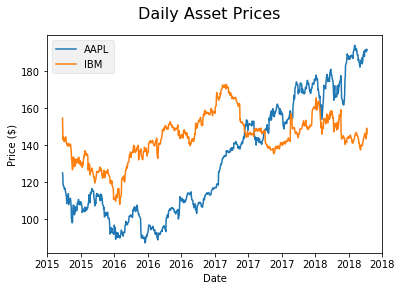

The correlation between AAPL and IBM is 0.416


In [5]:
PlotSeries()

## VaR (Value at Risk)

The VaR of a portfolio, \$$V$, is often stated as:

We are $X$ percent certain that we will not lose more than \$V in the next $N$ days

Often for regulatory purposes $X = 99$ and $N = 10$. We will now illustrate the two main approaches to a VaR calculation.

### Non-Parametric Estimation

In this approach we estimate the distribution of 10-day portfolio returns by looking at historical share prices. The following script imports three years of AAPL and IBM prices in CSV format. These were obtained from Quandl.com, but their API could be used to programmatically recalculate VaR in light of new market data.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbol_to_value = {"AAPL" : 500000, "IBM" : 200000}

def import_data():

    cols = list(symbol_to_value)
    
    symbol = cols[0]
    path = symbol + ".csv"
    dates = pd.read_csv(path, index_col = 'Date', parse_dates = True).index   
    market_data = pd.DataFrame( np.zeros((len(dates), len(cols))) , columns = cols)
        
    for symbol in cols:
        path = symbol + ".csv"
        market_data[symbol] = pd.read_csv(path)["Adj_Close"]
        
    return market_data

def portfolio_returns(days):
    
    market_data = import_data()    
    num_rows = len( market_data.index )
    num_simulations = int( np.floor( num_rows / days ) )
    
    # deal with day = 1 case
    if(days == 1):
        num_simulations -= 1
        days = 2
    
    portfolio_returns = []
    
    for i in range(num_simulations):
        portfolio_change = 0.0
        
        log_returns = np.matrix(np.log(market_data.iloc[i + days - 1]/market_data.iloc[i]))
        notionals = np.matrix(list(symbol_to_value.values()))
        portfolio_change = (notionals*log_returns.T).tolist()[0][0]
        
        portfolio_returns.append(portfolio_change)
        
    return pd.DataFrame( portfolio_returns )

def NonParametricVAR(percent, days):
    
    data = portfolio_returns(days)
    
    var = data.quantile(1 - percent/100)[0]
    string = "We are {}% certain that we will not lose more than ${} in the next {} days".format(percent, -var.round(0), days)
    print(string)
    
    plt.style.use(['bmh'])
    data.hist(bins = 20)
    plt.vlines(var, 0, 10, linestyles = 'dashed')
    plt.title("Distribution of {}-day logarithmic portfolio returns".format(days))
    plt.show()


We are 99% certain that we will not lose more than $71335.0 in the next 10 days


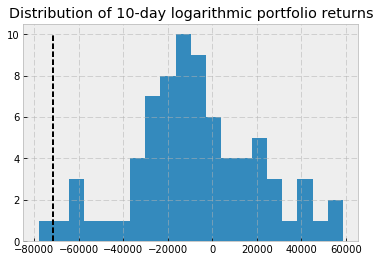

In [51]:
NonParametricVAR(99, 10)

The function NonParametricVAR() splits the three years up into 75 10-day simulation periods and calculates the logarithmic return of the portfolio over each one in order to build up a distribution. Each of these periods is treated as independent and the 99% VaR is then determined as the lower one percentile.

The histogram shows that we are estimating VaR in a tail of the distribution where we have very little data. One might argue that we should simply use more data. However, this is not always available for newer assets and, perhaps more importantly, the older the data is the less representative it becomes of the present. There are techniques that enable one to exploit vast historical data, if it is available, whilst noting that recent data is much more relevant. For example, one could weight historical samples in favour of the present, see [1](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=51420).

A common method to get around this issue is to calculate the 1-day VaR and scale it by $\sqrt{N}$. This *square-root of time* rule, see [2](https://www.researchgate.net/publication/238231953_Extrapolating_VaR_by_the_Square-Root_Rule), only holds if the asset prices follow Geometric Brownian Motion: logarithmic returns are independent and Normally distributed with a zero mean. While restrictive, this technique is explicitly endorsed by many regulators.

In [52]:
def ScaledNonParametricVAR(percent, days):
    
    data = portfolio_returns(1)
    
    var = data.quantile(1 - percent/100)[0]
    
    plt.style.use(['bmh'])
    data.hist(bins = 20)
    plt.vlines(var, 0, 175, linestyles = 'dashed')
    plt.title("Distribution of 1-day logarithmic portfolio returns")
    
    var = var * np.sqrt(days)
    string = "We are {}% certain that we will not lose more than ${} in the next {} days".format(percent, -var.round(0), days)
    print(string)
    
    plt.show()

We are 99% certain that we will not lose more than $76517.0 in the next 10 days


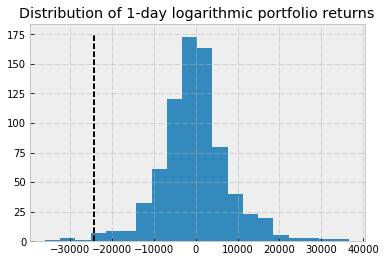

In [53]:
ScaledNonParametricVAR(99, 10)

The function ScaledNonParametricVAR() above uses this technique. By looking at 1-day returns we have many more simulations from which to build our distribution. The assumption of a zero mean, at least, seems sound in this instance. The histogram does indeed look less sparse, computing a 10-day VaR that is around \$5,000 higher than our previous methodology. One might argue that this larger VaR is safer from a risk management perspective. However, of course, it could have turned out lower. In addition, since regulators use VaR to determine capital adequacy, overestimating it can be very costly.

Another possible technique, to avoid the GBM assumptions underlying the square-root rule, could be to use a 10-day rolling window. Whilst this would provide us with more 10-day samples, they would no longer be independent of one another due to the overlapping days. This produces an effective sample size that is much smaller than the actual sample size. Whilst estimates would not be biased, they would be very noisy as any given outlier would now appear in 10 different samples.

Another approach is to attempt to model the sparse tails of the 10-day returns distribution using Extreme Value Theory.

### Parametric Estimation

Whilst the previous technique assumed nothing about the distribution of returns, here we will take a parametric approach. We will assume that the 1-day returns can be modelled as a Normal distribution and then scale this up to a 10-day VaR as before.

In [54]:
import scipy.stats as stats

def ScaledNormalParametricVAR(percent, days):
    
    data = portfolio_returns(1)
    sorted_data = sorted(list(data[0]))
    
    mean = np.mean(sorted_data)
    std = np.std(sorted_data)
    var = mean + std*stats.norm.ppf(1 - percent/100)
    
    fit = stats.norm.pdf(sorted_data, mean, std)
    plt.plot(sorted_data, fit, '-')
    plt.hist(data, normed = True, bins = 20)
    plt.vlines(var, 0, 0.00006, linestyles = 'dashed')
    plt.title("Distribution of 1-day logarithmic portfolio returns")
    
    var = var * np.sqrt(days)
    string = "We are {}% certain that we will not lose more than ${} in the next {} days".format(percent, -var.round(0), days)
    print(string)
    
    plt.show()    

We are 99% certain that we will not lose more than $62671.0 in the next 10 days


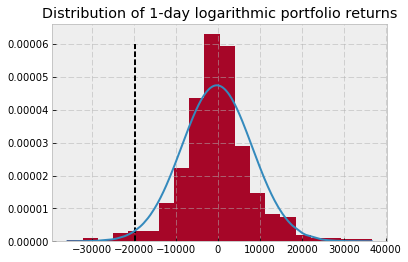

In [55]:
ScaledNormalParametricVAR(99, 10)

It is clear that a Normal distribution does not well fit the portfolio returns. In reality the returns are much more concentrated around the origin. Also it poorly models the fat tails, exactly the extremes that VaR is attempting to quantify. Consequently, when compared to ScaledNonParametricVAR() it underpredicts VaR by over $10,000.

It is well documented that a Student's t-distribution often fits financial returns better than a Normal distribution due to its added *degrees of freedom* parameter: $\nu$. If $\nu=1$ then the t-distribution collapses to a Cauchy distribution and as $\nu \rightarrow \infty$ it tends back to a Normal distribution. The function ScaledStudentParametricVAR() below fits a t-distribution to the 1-day returns by estimating the three required parameters. It uses a built-in routine to iteratively perform a Maximum Likelihood Estimation.

In [56]:
def ScaledStudentParametricVAR(percent, days):
    
    data = portfolio_returns(1)
    sorted_data = sorted(list(data[0]))
    
    params = stats.t.fit(sorted_data)
    df = params[0]
    loc = params[1]
    scale = params[2]

    var = loc + scale*stats.t.ppf(1 - percent/100, df)    
    
    fit = stats.t.pdf(sorted_data, df, loc, scale)
    plt.plot(sorted_data, fit, '-')
    plt.hist(data, normed = True, bins = 20)
    plt.vlines(var, 0, 0.00006, linestyles = 'dashed')
    plt.title("Distribution of 1-day logarithmic portfolio returns")
    
    var = var * np.sqrt(days)
    string = "We are {}% certain that we will not lose more than ${} in the next {} days".format(percent, -var.round(0), days)
    print(string)
    
    plt.show()    
    

We are 99% certain that we will not lose more than $78197.0 in the next 10 days


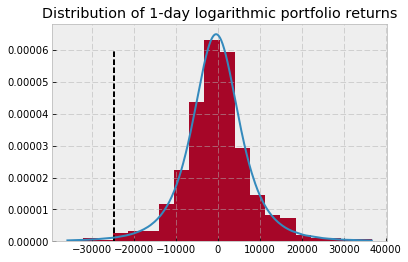

In [57]:
ScaledStudentParametricVAR(99,10)

It is immediately clear that the t-distribution fits the 1-day returns much better. It better captures the concentration of returns around the origin as well as the fat tails. Note that it can be shown that the t-distribution is a mixture of Normal distributions: each with the same mean but with variances sampled from an Inverse Gamma distribution. In other words, the t-distribution can be viewed as a Normal distribution with a variance that jumps around. This simultaneously accounts for its more concentrated centre (when the sampled variance is low) and fatter tails (when the sampled variance is high).

Using this parameterisation, the predicted VaR much better matches that calculated by ScaledNonParametricVAR() - overestimating by around \$2000.

VaR is the most popular measure of risk amongst risk managers and regulators. It is simple to calculate and, since it is really just estimating percentiles, is particularly resistant to outliers. However, it can be shown that VaR is not a *coherent risk measure*, see [3](https://en.wikipedia.org/wiki/Coherent_risk_measure). This is because it is not sub-additive. That is, it is possible that the VaR of a combination of two portfolios is larger than the sum of their individual VaRs:

$\text{VaR}(P_1 + P_2) > \text{VaR}(P_1) + \text{VaR}(P_2)$

This is an undesirable property for a risk measure, since there should be some diversification benefits from holding the two portfolios together. Even in the worst case, when the two portfolios are perfectly correlated, we would expect their combined VaR to equal the sum of their individual VaRs.

## cVaR (Conditional Value at Risk or Expected Shortfall)

The cVaR of a portfolio, \$$V$, is often stated as:

Assuming the worst $X$ percent of scenarios, we expect to lose \$V in the next $N$ days

Whilst VaR answers the question "*How bad can things get?*", cVaR answers the question "*If things get bad and we cross the VaR barrier, how much can we expect to lose?*". cVaR is a coherent risk measure.

There is also a relationship between cVaR and VaR. Let $\text{VaR}_\alpha$ be the VaR of a portfolio over the next $N$ days at the $\alpha\text{-percentile}$, where $\alpha \in (0,1)$. For example, earlier we calculated $\text{VaR}_{0.01}$. Suppose that portfolio returns over the next $N$ days, $R$, follow a distribution with cumulative density function $F(r)$ and probability density function $f(r)$. Since VaR is simply the lower percentile:

$\text{VaR}_\alpha(R) = F^{-1}(\alpha)$.

Let $\text{cVaR}_\alpha$ be similarly defined, then:

$\text{cVaR}_\alpha(R) = \text{E}[R|R<F^{-1}(\alpha)] = \frac{1}{\alpha}\int_{-\infty}^{F^{-1}(\alpha)}xf(x) dx$

From here it is clear that $\text{cVaR}_1$ simply collapses to the expectation of portfolio returns over the next $N$ days. By making the substitution $t=F(x)$ and noting that $F'(x) = f(x)$, one obtains the form:

$\text{cVaR}_\alpha(R) = \frac{1}{\alpha}\int_{0}^{\alpha}F^{-1}(t) dt = \frac{1}{\alpha}\int_{0}^{\alpha}\text{VaR}_t(R)dt$

From here, one can show that cVaR is greater than or equal to VaR at the same confidence level: $\text{cVaR}_\alpha(R) \geq \text{VaR}_\alpha(R)$.

It is expected that Basel IV will replace a 10-day $\text{VaR}_{0.01}$ with a 10-day $\text{cVaR}_{0.025}$. Under GBM assumptions these can be shown to be approximately equal. However, in reality cVaR can be significantly larger since it accounts for tail events that VaR largely ignores. Again, we will consider two methods of calculation.

### Non-Parametric Estimation

The function NonParametricCVAR() below begins with the distribution of 10-day returns and computes the expectation given that we're in the lower 2.5 percentile - highlighted by the blue area. This is around \$2000 larger than the $\text{VaR}_{0.01}$ calculated previously.


In [58]:
def NonParametricCVAR(percent, days):
    
    data = portfolio_returns(days)
    
    var = data.quantile(percent/100)[0]
        
    cvar = np.mean(data[data < var])[0]    
    
    string = "Assuming the worst {}% of scenarios, we expect to lose ${} in the next {} days".format(percent, -cvar.round(0), days)
    print(string)
        
    lower_end = data[data <= var]
    lower_end.dropna(inplace=True)
    
    upper_end = data[data >= var]
    upper_end.dropna(inplace=True)
            
    plt.style.use(['bmh'])
    plt.hist(lower_end, bins=2)
    plt.hist(upper_end, bins=20)
    plt.vlines(cvar, 0, 10, linestyles = 'dashed')
    plt.title("Distribution of {}-day logarithmic portfolio returns".format(days))
    plt.show()


Assuming the worst 2.5% of scenarios, we expect to lose $73477.0 in the next 10 days


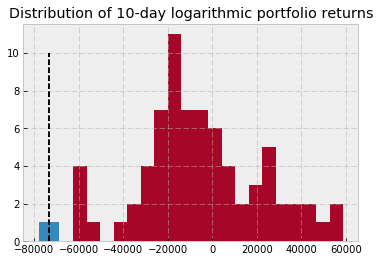

In [59]:
NonParametricCVAR(2.5, 10)

In an effort to overcome the sparseness of this tail, we will scale the 1-day cVaR up to a 10-day estimation as performed previously for VaR.

In [60]:
def ScaledNonParametricCVAR(percent, days):
    
    data = portfolio_returns(1)
    
    var = data.quantile(percent/100)[0]
    
    cvar = np.mean(data[data < var])[0]
    
    lower_end = data[data <= var]
    lower_end.dropna(inplace=True)
    
    upper_end = data[data >= var]
    upper_end.dropna(inplace=True)
            
    plt.style.use(['bmh'])
    plt.hist(lower_end, bins=7)
    plt.hist(upper_end, bins=20)
    plt.vlines(cvar, 0, 125, linestyles = 'dashed')
    plt.title("Distribution of 1-day logarithmic portfolio returns".format(days))
    
    cvar = cvar * np.sqrt(days)
    string = "Assuming the worst {}% of scenarios, we expect to lose ${} in the next {} days".format(percent, -cvar.round(0), days)
    print(string)
    
    plt.show()

Assuming the worst 2.5% of scenarios, we expect to lose $74934.0 in the next 10 days


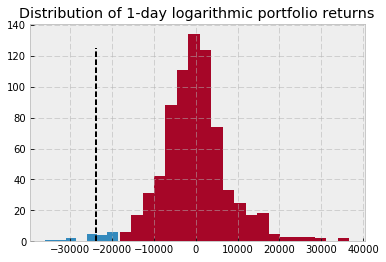

In [61]:
ScaledNonParametricCVAR(2.5, 10)

The scaling technique seems more consistent in this particular case, compared to when we applied it to VaR, being only around $1000 larger than that calculated directly from the 10-day returns. In addition, it is clearly derived from a more robust estimate of the returns distribution rather than one or two data points.

### Parametric Estimation

We have already seen that a Normal distribution does not well model the returns data. Thus we will jump straight to modelling the 1-day returns with a Student's t-distribution and scale this up to a 10-day cVaR.

It can be readily shown, see [4](http://www.maths.manchester.ac.uk/~saralees/chap17.pdf), that if returns follow a general Student's t-distribution $R\sim t(\mu, \sigma^2, \nu)$ then:

$\text{cVaR}_\alpha(R) = \mu + \sigma\frac{f_\nu[F^{-1}_\nu (\alpha)]}{\alpha}\frac{\nu + [F^{-1}_\nu (\alpha)]^2}{\nu -1}$

where $f_\nu$ and $F_\nu$ are respectively the probability and cumulative density functions of the standard t-distribution: $t(0, 1, \nu)$.

In [62]:
import math

def ScaledStudentParametricCVAR(percent, days):
    
    data = portfolio_returns(1)
    sorted_data = sorted(list(data[0]))
    
    params = stats.t.fit(sorted_data)
    df = params[0]
    loc = params[1]
    scale = params[2]
        
    numer = 100*stats.t.pdf( stats.t.ppf(percent/100, df) , df )*(df + math.pow(stats.t.ppf(percent/100, df), 2))
    denom = percent*(df - 1)
    
    cvar = loc + (scale*numer)/denom
    
    fit = stats.t.pdf(sorted_data, df, loc, scale)
    plt.plot(sorted_data, fit, '-')
    plt.hist(data, normed=True, bins = 20)
    plt.vlines(-cvar, 0, 0.00006, linestyles = 'dashed')
    plt.title("Distribution of 1-day logarithmic portfolio returns")
    
    cvar = cvar * np.sqrt(days)
    string = "Assuming the worst {}% of scenarios, we expect to lose ${} in the next {} days".format(percent, cvar.round(0), days)
    print(string)
    
    plt.show()    

Assuming the worst 2.5% of scenarios, we expect to lose $82624.0 in the next 10 days


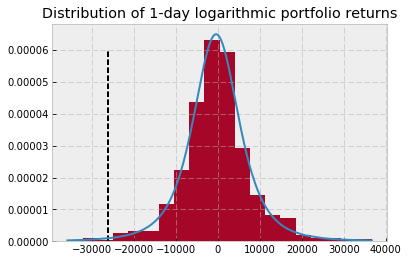

In [63]:
ScaledStudentParametricCVAR(2.5, 10)

It is when estimating cVaR parametrically that we can really distinguish it from VaR. cVaR performs a conditional expectation in the unbounded fat tail of the t-distribution, producing a risk measure that is around \$7000 more conservative than ScaledNonParametricCVAR().

## Derivative Portfolios

Here we have only considered a portfolio consisting of simple linear instruments. It was very easy to evaluate the portfolio's value at the end of each day. However, suppose that our portfolio contained instruments whose payoff depends non-linearly on the underlying, such as options. There is not a ticker-tape of historical market option prices on each possible underlying for each maturity date and strike. This eliminates the non-parametric approach.

Instead, one has to parametrically determine the returns distribution using Monte Carlo simulation. One would first use today's market values to price the current state of the portfolio. Next one would simulate each market variable required in the pricing model (e.g. spot prices, volatility, interest rates) 10 days forwards, re-evaluate the portfolio and hence determine the return. This would be performed many times to accumulate the returns distribution, from which VaR or cVaR could be calculated.

This process can be very computationally intensive. Instead, many institutions assume that the change in value of the portfolio over one day is small, and so approximate it with a Taylor Expansion. In this way each simulation is much less onerous and the returns distribution can be accumulated more quickly. The risk metric could then be scaled up to 10-days using the square-root-of-time rule.

## Summary

One will always fail in attempting to represent the risk of a portfolio with a single number - simply too much information is lost. VaR and cVaR ask different questions and each has its merits. In reality, one should employ both statistics quoted at several different confidence levels to really comprehend the full returns distribution.

In estimating 10-day VaR or cVaR the usual time-series trade-off has arisen: robust statistical estimates using a longer lookback period Vs relevant statistical estimates using a shorter lookback period. Different disciplines handle this trade-off in different ways, depending on how stationary one believes the underlying data-generating processes are. There is arguably no one best solution in finance, with different asset classes undergoing regime changes at varying rates.

Historically weighted sampling, rolling-window sampling, square-root-of-time rule and Extreme Value Theory are all attempts to address this trade-off, each introducing their own assumptions and moving us along the continuum from completely non-parametric to a fully parametric methodology.

Here, we have seen that using the square-root-of-time rule to scale from 1-day to 10-day statistics tends to produce more conservative estimates than one obtains directly from the, less robust, 10-day distributions. This is by no means always true and depends on exactly the way in which the data violates it's assumptions. One incontrovertible truth, at the fully parametric end of the continuum, seems to be that t-distributions much better model returns than Normal distributions.

Whichever set of methods are selected, one should fully backtest the result. This means validating any assumptions used (goodness-of-fit distribution tests, independence tests) as well as backtesting whether the final statistic itself reflected the historical data.